In [1]:
import pandas as pd
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
# Conexion a drive y descompresión de los corpus
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
fichero.split("_")[1].split(".")

['es25', 'csv']

In [17]:
ficheros = ['submission_es25.csv','submission_es50.csv', 'submission_en25.csv','submission_en50.csv','baseline_es25.csv','baseline_es50.csv', 'baseline_en25.csv','baseline_en50.csv']
i = 0

raiz = "/content/drive/MyDrive/COLAB - TFM/"
for fichero in ficheros:
  if i == 0:
    df_resultado = pd.read_csv(raiz+fichero, sep=";", index_col=0)
    df_resultado["archivo"] = fichero.split("_")[0]
    df_resultado["MAX_LEN"] = fichero.split("_")[1].split(".")[0][-2:]
    df_resultado["lan"] = fichero.split("_")[1].split(".")[0][:2]
    i += 1
  else:
    try:
      df_tmp = pd.read_csv(raiz+fichero, sep=";", index_col=0)
      df_tmp["archivo"] = fichero.split("_")[0]
      df_tmp["MAX_LEN"] = fichero.split("_")[1].split(".")[0][-2:]
      df_tmp["lan"] = fichero.split("_")[1].split(".")[0][:2]
      df_resultado = pd.concat([df_resultado, df_tmp], axis=0)
    except Exception as e:
      print(e)
      print(fichero)
  


50
25
50
25
50
25
50


In [18]:
df_resultado

,pred_tags,valid_tags,val_inputs,archivo,MAX_LEN,lan
0,B-Concept,O,la,submission,25,es
1,B-Concept,B-Concept,UNK,submission,25,es
2,I-Concept,O,UNK,submission,25,es
3,B-Concept,O,es,submission,25,es
4,I-Concept,B-Action,un,submission,25,es
...,...,...,...,...,...,...
2280,O,O,a,baseline,50,en
2281,O,O,UNK,baseline,50,en
2282,O,O,UNK,baseline,50,en
2283,O,O,at,baseline,50,en


In [19]:
df_resultado_postproceso = df_resultado.reset_index(drop=True).copy()
df_resultado_postproceso["num_entidad_prediccion"] = -1
df_resultado_postproceso["num_entidad_validacion"] = -1
num_entidad_training = 0
num_entidad_validacion = 0
for i, linea in tqdm(df_resultado_postproceso.iterrows()):
  if i > 0 and linea["pred_tags"].split("-")[0] != "O":
    bio_tag = linea["pred_tags"].split("-")[0]
    entidad = linea["pred_tags"].split("-")[1]
    # vemos cual es la anterior
    bio_anterior = df_resultado_postproceso["pred_tags"].iloc[i - 1]
    bio_tag_anterior = bio_anterior.split("-")[0]
    entidad_anterior = bio_anterior.split("-")[0]
    # vemos cual es el siguiente (en principio no es necesario)
    # bio_siguiente = df_resultado_postproceso["pred_tags"].iloc[i + 1]
    # bio_tag_siguiente = bio_siguiente.split("-")[0]
    # entidad_siguiente = bio_siguiente.split("-")[0]
    if bio_tag == "I" and bio_anterior == "O":
      #Si tenemos una inside pero la anterior es un outside, convertimos la I en una B.
      nueva_bio = "B-"+entidad
      df_resultado_postproceso.iloc[i,0] = nueva_bio
      # print(i, nueva_bio)
    if bio_tag == "I" and bio_anterior == "B" and entidad != entidad_anterior:
      #Comprobamos que la B y la I son homogeneas
      nueva_bio = "I-"+entidad_anterior
      df_resultado_postproceso.iloc[i,0] = nueva_bio
      # print(i, nueva_bio)
    if bio_tag == "I" and bio_anterior == "I" and entidad != entidad_anterior:
      #Comprobamos que la I y la I son homogeneas
      nueva_bio = "I-"+entidad_anterior
      df_resultado_postproceso.iloc[i,0] = nueva_bio
      # print(i, nueva_bio)

12244it [00:00, 13699.14it/s]


In [20]:
# Contamos las entidades
for i, linea in tqdm(df_resultado_postproceso.iterrows()):
  if (linea["pred_tags"].split("-")[0] != "O") | (linea["valid_tags"].split("-")[0] != "O"):
    if linea["pred_tags"].split("-")[0] != "O":
      bio_tag = linea["pred_tags"].split("-")[0]
      entidad = linea["pred_tags"].split("-")[1]
      if bio_tag == "B":
        df_resultado_postproceso.iloc[i,-2] = num_entidad_training
        num_entidad_training += 1
      elif bio_tag == "I":
        num_entidad_ant = df_resultado_postproceso["num_entidad_prediccion"].iloc[i - 1]
        df_resultado_postproceso.iloc[i,-2] = num_entidad_ant

    if linea["valid_tags"].split("-")[0] != "O":
      bio_tag = linea["valid_tags"].split("-")[0]
      entidad = linea["valid_tags"].split("-")[1]
      if bio_tag == "B":
        df_resultado_postproceso.iloc[i,-1] = num_entidad_validacion
        num_entidad_validacion += 1
      elif bio_tag == "I":
        num_entidad_ant = df_resultado_postproceso["num_entidad_validacion"].iloc[i - 1]
        df_resultado_postproceso.iloc[i,-1] = num_entidad_ant

12244it [00:04, 3008.27it/s]


In [21]:
def calcula_metricas(df_resultado_postproceso):
  if len(df_resultado_postproceso) > 0:
    df_resultado_postproceso.loc[:, "correcto"] = 0
    df_resultado_postproceso.loc[df_resultado_postproceso["pred_tags"] == df_resultado_postproceso["valid_tags"], "correcto"] = 1
    df_resultado_postproceso["alguna_entidad"] = 0
    df_resultado_postproceso.loc[(df_resultado_postproceso["num_entidad_prediccion"] != -1 ) |
                                (df_resultado_postproceso["num_entidad_validacion"] != -1),
                                "alguna_entidad"] = 1
    df_resumen = df_resultado_postproceso.groupby(["alguna_entidad", "num_entidad_prediccion", "num_entidad_validacion"])["correcto"].mean().reset_index()
    df_resumen.loc[df_resumen["correcto"] == 0, "correcto_tag"]  = "I"
    df_resumen.loc[(df_resumen["num_entidad_prediccion"].astype(int) < 0) & (df_resumen["num_entidad_validacion"].astype(int) > -1), "correcto_tag"]  = "M"
    df_resumen.loc[(df_resumen["num_entidad_prediccion"].astype(int) > -1) & (df_resumen["num_entidad_validacion"].astype(int) < 0), "correcto_tag"]  = "S"
    df_resumen.loc[(df_resumen["correcto"] > 0) & (df_resumen["correcto"] < 1), "correcto_tag"]  = "P"
    df_resumen.loc[(df_resumen["correcto"] == 1) , "correcto_tag"]  = "C"
    df_resumen_agregado = df_resumen["correcto_tag"].value_counts()
    try:
      C = df_resumen_agregado.loc["C"]
    except:
      print("No hay etiquetas C")
      C = 0
    try:
      P = df_resumen_agregado.loc["P"]    
    except:
      print("No hay etiquetas P")
      P = 0
    try:
      I = df_resumen_agregado.loc["I"]    
    except:
      print("No hay etiquetas I")
      I = 0
    try:
      S = df_resumen_agregado.loc["S"]    
    except:
      print("No hay etiquetas S")
      S = 0
    try:
      M = df_resumen_agregado.loc["M"]    
    except:
      print("No hay etiquetas M")
      M = 0
    precision = (C + 0.5 * P)/ (C +  P +  I +  S) 
    recall = (C + 0.5 * P)/ (C +  P +  I +  M) 
    f1 = 2 * (precision*recall) / (precision + recall)
    return precision, recall, f1
  else:
    return None, None, None

In [22]:
archivos = ["baseline", "submission"]
resultados = []
for archivo in archivos:
  prec, rec, f1 = calcula_metricas(df_resultado_postproceso.loc[(df_resultado_postproceso["archivo"] == archivo),:])
  resultados.append([archivo, prec, rec, f1])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [23]:
resultados

[['baseline', 0.20475227502527807, 0.2570884468895472, 0.22795497185741087],
 ['submission', 0.18097447795823665, 0.20508326029798424, 0.19227608874281016]]

In [ ]:
# Lo guardamos for if the flies
df_resultado_postproceso.to_csv(raiz + "resultado_post_proceso_una_longitud.csv")

In [ ]:

raiz = "/content/drive/MyDrive/COLAB - TFM/"
df_resultado_postproceso = pd.read_csv(raiz + "resultado_post_proceso_una_longitud.csv")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.rcParams["figure.figsize"] = (10,6)
sns.set_context('paper')
sns.set_style('ticks', {'axes.grid': True})


def plot_with_bars(data, std, color=None):
  if color != None:
    ax = sns.lineplot(data.iloc[:, 0], data.iloc[:, 1], color=color, markers=True, linewidth = 2)
    ax.fill_between(data.iloc[:, 0], data.iloc[:, 1] - std, data.iloc[:, 1] + std, alpha=0.1, color=color)
    sns.despine()
  else:
    ax = sns.lineplot(data.iloc[:, 0], data.iloc[:, 1], markers=True, linewidth = 2)
    ax.fill_between(data.iloc[:, 0], data.iloc[:, 1] - std, data.iloc[:, 1] + std, alpha=0.1)
    sns.despine()



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

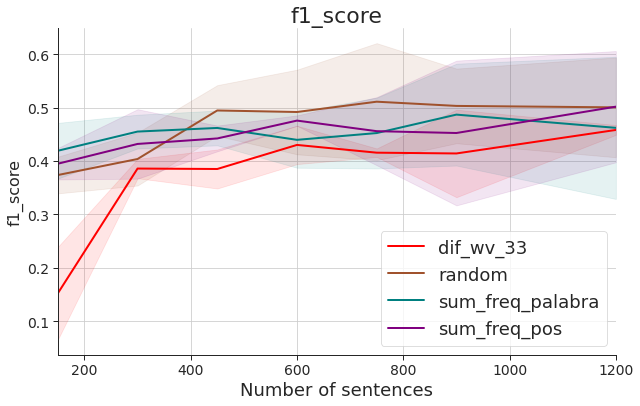

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

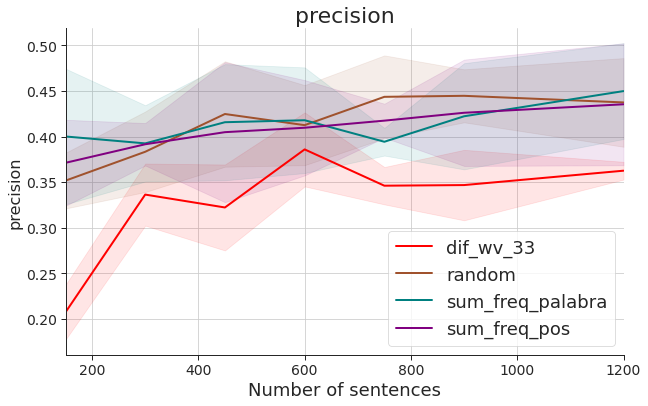

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

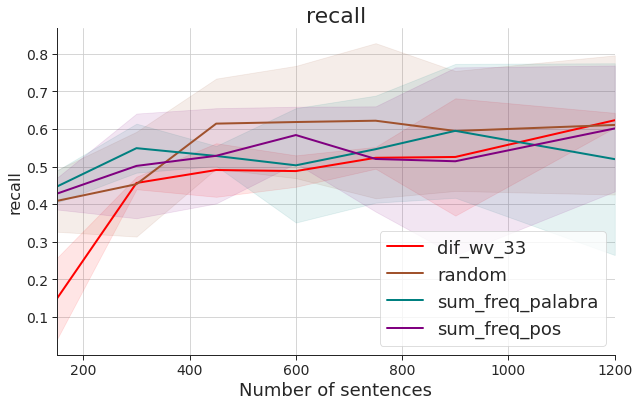

In [ ]:
resultados = []
for iteracion in range(5):
  for archivo in df_resultado_postproceso["archivo"].unique():
    for num in df_resultado_postproceso["num"].unique():
      prec, rec, f1 = calcula_metricas(df_resultado_postproceso.loc[(df_resultado_postproceso["num"] == num) &
                                                                     (df_resultado_postproceso["archivo"] == archivo) &
                                                                     (df_resultado_postproceso["iteracion"] == iteracion),:])
      resultados.append([iteracion, archivo, num, prec, rec, f1])
df_val = pd.DataFrame(resultados, columns=["iteracion", "dataset", "num_palabras","precision", "recall", "f1_score"])
df_val_agg = df_val.groupby(["dataset", "num_palabras"]).agg({"precision": [np.mean, np.std], "recall": [np.mean, np.std],"f1_score": [np.mean, np.std]}).reset_index()

metricas = ["f1_score", "precision", "recall"]
color_dict = {0: "red", 1: "sienna", 2: "teal", 3: "purple"}
for metrica in metricas:
  labels=[]
  for color_id, dataset in enumerate(df_val_agg["dataset"].unique()):
    df_tmp = pd.concat([df_val_agg[df_val_agg["dataset"] == dataset]["num_palabras"], df_val_agg[df_val_agg["dataset"] == dataset][(metrica, "mean")]],axis=1)
    df_tmp.columns = ["num_palabras", metrica]
    plot_with_bars( df_tmp, df_val_agg.loc[df_val_agg["dataset"] == dataset][(metrica, "std")].values, color=color_dict[color_id])
    labels.append(dataset)
  plt.legend(labels=labels, prop={'size': 18})
  plt.title(metrica, size=22)
  plt.xlim([150,1200])
  plt.xlabel('Number of sentences', fontsize=18)
  plt.ylabel(metrica, fontsize=16)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.savefig(raiz+metrica+"_general_una_long.svg")
  plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

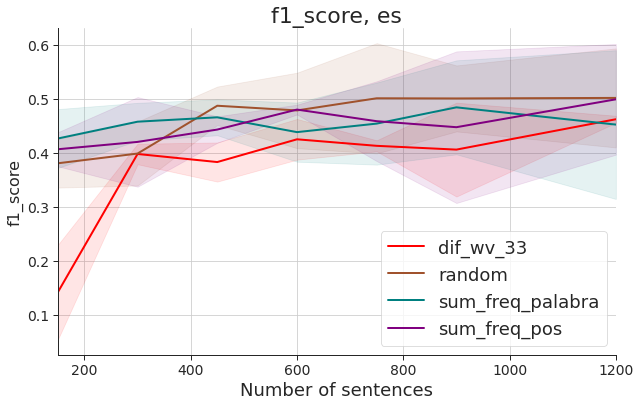

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

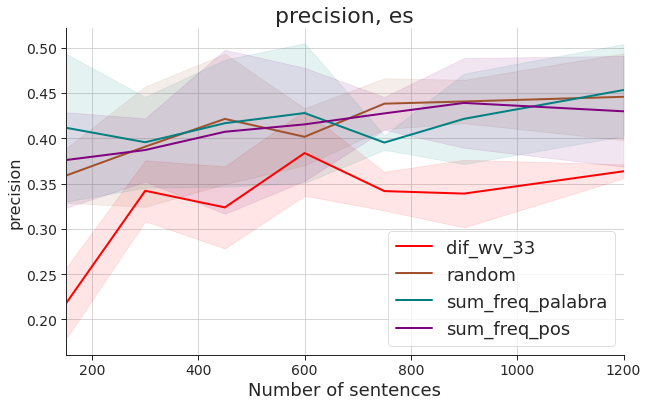

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

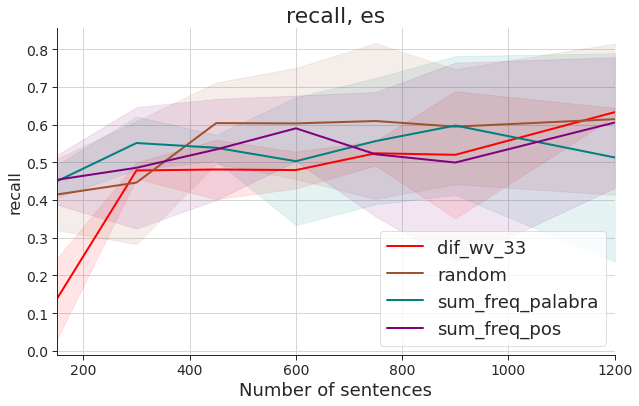

In [ ]:
resultados = []
for iteracion in range(5):
  for archivo in df_resultado_postproceso["archivo"].unique():
    for num in df_resultado_postproceso["num"].unique():
      prec, rec, f1 = calcula_metricas(df_resultado_postproceso.loc[(df_resultado_postproceso["lan"] == "es") &
                                                                    (df_resultado_postproceso["num"] == num) &
                                                                     (df_resultado_postproceso["archivo"] == archivo) &
                                                                     (df_resultado_postproceso["iteracion"] == iteracion),:])
      resultados.append([iteracion, archivo, num, prec, rec, f1])
df_val = pd.DataFrame(resultados, columns=["iteracion", "dataset", "num_palabras","precision", "recall", "f1_score"])
df_val_agg = df_val.groupby(["dataset", "num_palabras"]).agg({"precision": [np.mean, np.std], "recall": [np.mean, np.std],"f1_score": [np.mean, np.std]}).reset_index()
metricas = ["f1_score", "precision", "recall"]
color_dict = {0: "red", 1: "sienna", 2: "teal", 3: "purple"}
for metrica in metricas:
  labels=[]
  for color_id, dataset in enumerate(df_val_agg["dataset"].unique()):
    df_tmp = pd.concat([df_val_agg[df_val_agg["dataset"] == dataset]["num_palabras"], df_val_agg[df_val_agg["dataset"] == dataset][(metrica, "mean")]],axis=1)
    df_tmp.columns = ["num_palabras", metrica]
    plot_with_bars( df_tmp, df_val_agg.loc[df_val_agg["dataset"] == dataset][(metrica, "std")].values, color=color_dict[color_id])
    labels.append(dataset)
  plt.legend(labels=labels, prop={'size': 18})
  plt.title(metrica+ ", es", size=22)
  plt.xlim([150,1200])
  plt.xlabel('Number of sentences', fontsize=18)
  plt.ylabel(metrica, fontsize=16)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.savefig(raiz+metrica+"_es_una_long.svg")
  plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

No hay etiquetas P
No hay etiquetas P
No hay etiquetas C
No hay etiquetas I
No hay etiquetas S
No hay etiquetas P


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

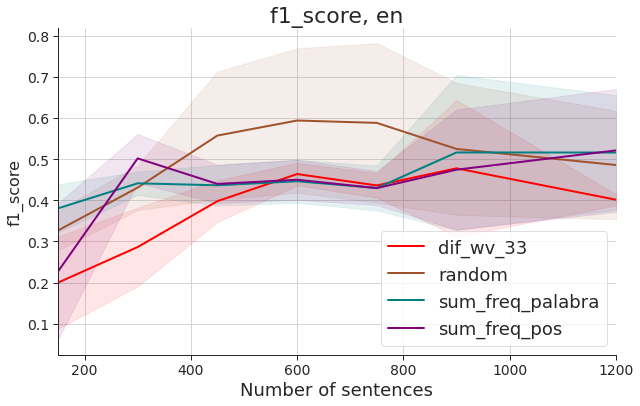

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

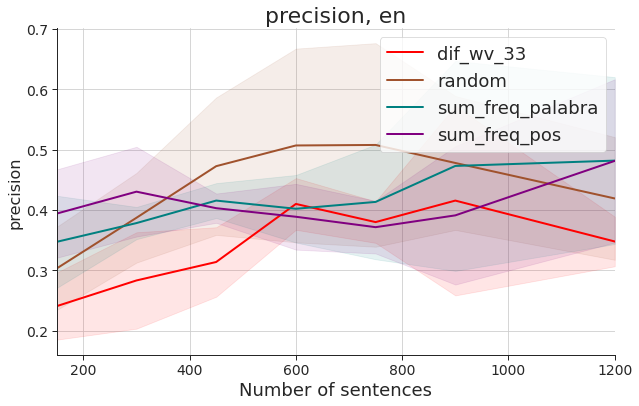

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

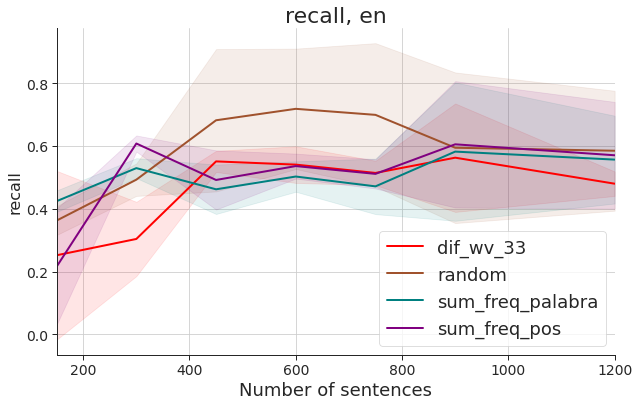

In [ ]:
resultados = []
for iteracion in range(5):
  for archivo in df_resultado_postproceso["archivo"].unique():
    for num in df_resultado_postproceso["num"].unique():
      prec, rec, f1 = calcula_metricas(df_resultado_postproceso.loc[(df_resultado_postproceso["lan"] == "en") &
                                                                    (df_resultado_postproceso["num"] == num) &
                                                                     (df_resultado_postproceso["archivo"] == archivo) &
                                                                     (df_resultado_postproceso["iteracion"] == iteracion),:])
      resultados.append([iteracion, archivo, num, prec, rec, f1])
df_val = pd.DataFrame(resultados, columns=["iteracion", "dataset", "num_palabras","precision", "recall", "f1_score"])
df_val_agg = df_val.groupby(["dataset", "num_palabras"]).agg({"precision": [np.mean, np.std], "recall": [np.mean, np.std],"f1_score": [np.mean, np.std]}).reset_index()
metricas = ["f1_score", "precision", "recall"]
color_dict = {0: "red", 1: "sienna", 2: "teal", 3: "purple"}
for metrica in metricas:
  labels=[]
  for color_id, dataset in enumerate(df_val_agg["dataset"].unique()):
    df_tmp = pd.concat([df_val_agg[df_val_agg["dataset"] == dataset]["num_palabras"], df_val_agg[df_val_agg["dataset"] == dataset][(metrica, "mean")]],axis=1)
    df_tmp.columns = ["num_palabras", metrica]
    plot_with_bars( df_tmp, df_val_agg.loc[df_val_agg["dataset"] == dataset][(metrica, "std")].values, color=color_dict[color_id])
    labels.append(dataset)
  plt.legend(labels=labels, prop={'size': 18})
  plt.title(metrica+ ", en", size=22)
  plt.xlim([150,1200])
  plt.xlabel('Number of sentences', fontsize=18)
  plt.ylabel(metrica, fontsize=16)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.savefig(raiz+metrica+"_en_una_long.svg")
  plt.show()

In [ ]:
# PASAMOS AL ANALISIS DE LAS DOS LONGITUDES

In [ ]:
sufijos = ['_sum_freq_palabra.csv','_sum_freq_pos.csv', '_dif_wv_33.csv', '_random.csv']
i = 0
N_ITERACIONES = 5
for iteracion in range(N_ITERACIONES):
  for  suf in sufijos:
    raiz = "/content/drive/MyDrive/COLAB - TFM/"
    for MAX_LEN in [25,50]: 
      num_reg = [150, 300, 450, 600, 750, 900, 1200]
      for num in num_reg:
          for lan in ["en", "es"]:
            resultado = "resultado_"+str(num)+suf
            # print(raiz+resultado+"_validacion_"+str(MAX_LEN)+"_"+lan+".csv")
            if i == 0:
              df_resultado = pd.read_csv(raiz+resultado+"_validacion_"+str(MAX_LEN) + "_iter"+str(iteracion)+"_"+lan+".csv", sep=";", index_col=0)
              df_resultado["archivo"] = suf.split(".")[0][1:]
              df_resultado["MAX_LEN"] = MAX_LEN
              df_resultado["lan"] = lan
              df_resultado["num"] = num
              df_resultado["iteracion"] = iteracion
              i += 1
            else:
              try:
                df_tmp = pd.read_csv(raiz+resultado+"_validacion_"+str(MAX_LEN) + "_iter"+str(iteracion)+"_"+lan+".csv", sep=";", index_col=0)
                df_tmp["archivo"] = suf.split(".")[0][1:]
                df_tmp["MAX_LEN"] = MAX_LEN
                df_tmp["lan"] = lan
                df_tmp["num"] = num
                df_tmp["iteracion"] = iteracion
                df_resultado = pd.concat([df_resultado, df_tmp], axis=0)
              except:
                print(raiz+resultado+"_validacion_"+str(MAX_LEN) + "_iter"+str(iteracion)+"_"+lan+".csv")
            
            print(iteracion, len(df_resultado))


0 400
0 4573
0 4989
0 9215
0 9631
0 13857
0 14273
0 18499
0 18915
0 23141
0 23557
0 27783
0 28199
0 32425
0 32893
0 34452
0 34943
0 36078
0 36569
0 37704
0 38195
0 39330
0 39821
0 40956
0 41447
0 42582
0 43073
0 44208
0 44608
0 48781
0 49197
0 53423
0 53839
0 58065
0 58481
0 62707
0 63123
0 67349
0 67765
0 71991
0 72407
0 76633
0 77101
0 78660
0 79151
0 80286
0 80777
0 81912
0 82403
0 83538
0 84029
0 85164
0 85655
0 86790
0 87281
0 88416
0 88816
0 92989
0 93405
0 97631
0 98047
0 102273
0 102689
0 106915
0 107331
0 111557
0 111973
0 116199
0 116615
0 120841
0 121309
0 122868
0 123359
0 124494
0 124985
0 126120
0 126611
0 127746
0 128237
0 129372
0 129863
0 130998
0 131489
0 132624
0 133024
0 137197
0 137613
0 141839
0 142255
0 146481
0 146897
0 151123
0 151539
0 155765
0 156181
0 160407
0 160823
0 165049
0 165517
0 167076
0 167567
0 168702
0 169193
0 170328
0 170819
0 171954
0 172445
0 173580
0 174071
0 175206
0 175697
0 176832
1 177230
1 181442
1 181858
1 186084
1 186500
1 190726
1 191

In [ ]:
df_resultado_postproceso = df_resultado.reset_index(drop=True).copy()
df_resultado_postproceso["num_entidad_prediccion"] = -1
df_resultado_postproceso["num_entidad_validacion"] = -1
num_entidad_training = 0
num_entidad_validacion = 0
for i, linea in tqdm(df_resultado_postproceso.iterrows()):
  if i > 0 and linea["pred_tags"].split("-")[0] != "O":
    bio_tag = linea["pred_tags"].split("-")[0]
    entidad = linea["pred_tags"].split("-")[1]
    # vemos cual es la anterior
    bio_anterior = df_resultado_postproceso["pred_tags"].iloc[i - 1]
    bio_tag_anterior = bio_anterior.split("-")[0]
    entidad_anterior = bio_anterior.split("-")[0]
    # vemos cual es el siguiente (en principio no es necesario)
    # bio_siguiente = df_resultado_postproceso["pred_tags"].iloc[i + 1]
    # bio_tag_siguiente = bio_siguiente.split("-")[0]
    # entidad_siguiente = bio_siguiente.split("-")[0]
    if bio_tag == "I" and bio_anterior == "O":
      #Si tenemos una inside pero la anterior es un outside, convertimos la I en una B.
      nueva_bio = "B-"+entidad
      df_resultado_postproceso.iloc[i,0] = nueva_bio
      # print(i, nueva_bio)
    if bio_tag == "I" and bio_anterior == "B" and entidad != entidad_anterior:
      #Comprobamos que la B y la I son homogeneas
      nueva_bio = "I-"+entidad_anterior
      df_resultado_postproceso.iloc[i,0] = nueva_bio
      # print(i, nueva_bio)
    if bio_tag == "I" and bio_anterior == "I" and entidad != entidad_anterior:
      #Comprobamos que la I y la I son homogeneas
      nueva_bio = "I-"+entidad_anterior
      df_resultado_postproceso.iloc[i,0] = nueva_bio
      # print(i, nueva_bio)

883897it [02:40, 5490.76it/s]


In [ ]:
# Contamos las entidades
for i, linea in tqdm(df_resultado_postproceso.iterrows()):
  if (linea["pred_tags"].split("-")[0] != "O") | (linea["valid_tags"].split("-")[0] != "O"):
    if linea["pred_tags"].split("-")[0] != "O":
      bio_tag = linea["pred_tags"].split("-")[0]
      entidad = linea["pred_tags"].split("-")[1]
      if bio_tag == "B":
        df_resultado_postproceso.iloc[i,-2] = num_entidad_training
        num_entidad_training += 1
      elif bio_tag == "I":
        num_entidad_ant = df_resultado_postproceso["num_entidad_prediccion"].iloc[i - 1]
        df_resultado_postproceso.iloc[i,-2] = num_entidad_ant

    if linea["valid_tags"].split("-")[0] != "O":
      bio_tag = linea["valid_tags"].split("-")[0]
      entidad = linea["valid_tags"].split("-")[1]
      if bio_tag == "B":
        df_resultado_postproceso.iloc[i,-1] = num_entidad_validacion
        num_entidad_validacion += 1
      elif bio_tag == "I":
        num_entidad_ant = df_resultado_postproceso["num_entidad_validacion"].iloc[i - 1]
        df_resultado_postproceso.iloc[i,-1] = num_entidad_ant

883897it [1:06:56, 220.07it/s]


In [ ]:
# Lo guardamos for if the flies
df_resultado_postproceso.to_csv(raiz + "resultado_post_proceso_dos_longitudes.csv")

In [ ]:

df_resultado_postproceso = pd.read_csv(raiz + "resultado_post_proceso_dos_longitudes.csv")

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

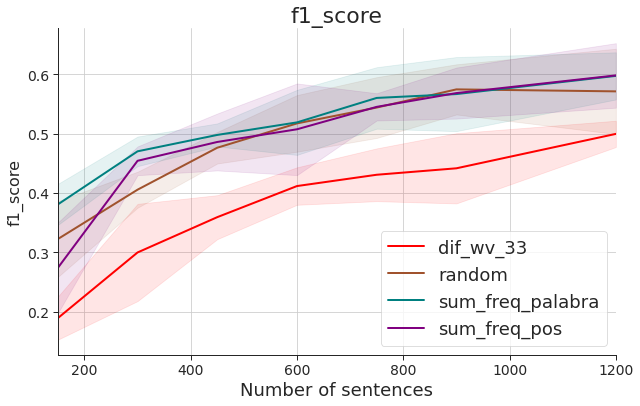

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

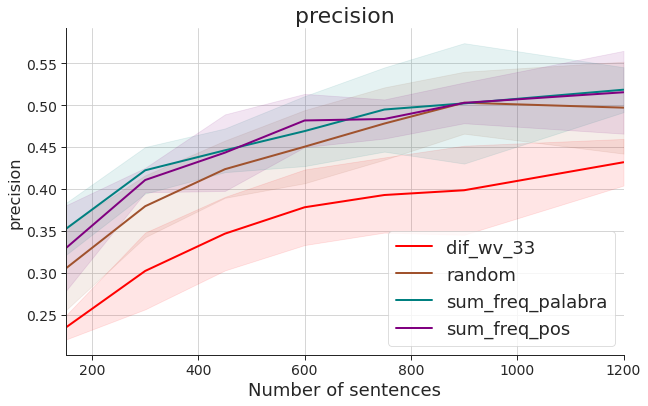

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

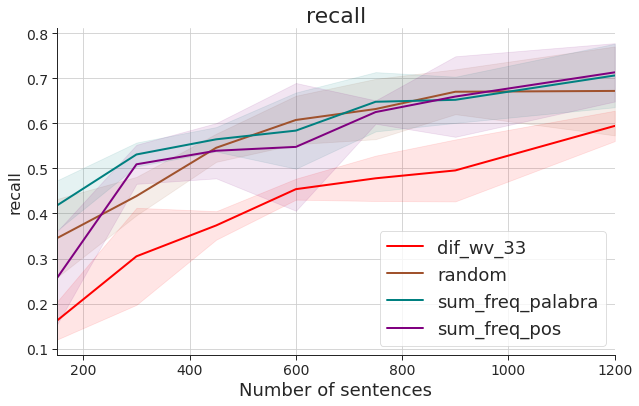

In [ ]:
resultados = []
for iteracion in range(5):
  for archivo in df_resultado_postproceso["archivo"].unique():
    for num in df_resultado_postproceso["num"].unique():
      prec, rec, f1 = calcula_metricas(df_resultado_postproceso.loc[(df_resultado_postproceso["num"] == num) &
                                                                     (df_resultado_postproceso["archivo"] == archivo) &
                                                                     (df_resultado_postproceso["iteracion"] == iteracion),:])
      resultados.append([iteracion, archivo, num, prec, rec, f1])
df_val = pd.DataFrame(resultados, columns=["iteracion", "dataset", "num_palabras","precision", "recall", "f1_score"])
df_val_agg = df_val.groupby(["dataset", "num_palabras"]).agg({"precision": [np.mean, np.std], "recall": [np.mean, np.std],"f1_score": [np.mean, np.std]}).reset_index()

metricas = ["f1_score", "precision", "recall"]
color_dict = {0: "red", 1: "sienna", 2: "teal", 3: "purple"}
for metrica in metricas:
  labels=[]
  for color_id, dataset in enumerate(df_val_agg["dataset"].unique()):
    df_tmp = pd.concat([df_val_agg[df_val_agg["dataset"] == dataset]["num_palabras"], df_val_agg[df_val_agg["dataset"] == dataset][(metrica, "mean")]],axis=1)
    df_tmp.columns = ["num_palabras", metrica]
    plot_with_bars( df_tmp, df_val_agg.loc[df_val_agg["dataset"] == dataset][(metrica, "std")].values, color=color_dict[color_id])
    labels.append(dataset)
  plt.legend(labels=labels, prop={'size': 18})
  plt.title(metrica, size=22)
  plt.xlim([150,1200])
  plt.xlabel('Number of sentences', fontsize=18)
  plt.ylabel(metrica, fontsize=16)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.savefig(raiz+metrica+"_general_dos_long.svg")
  plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

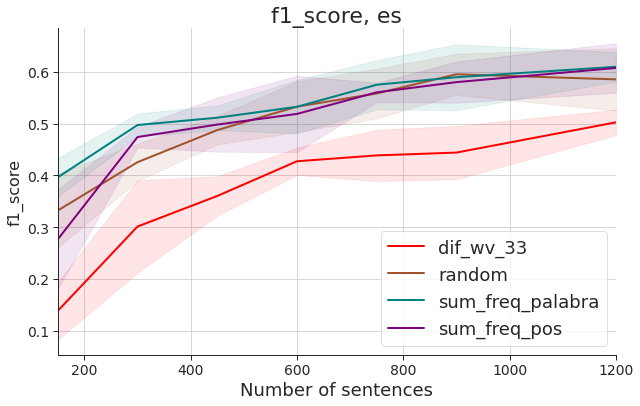

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

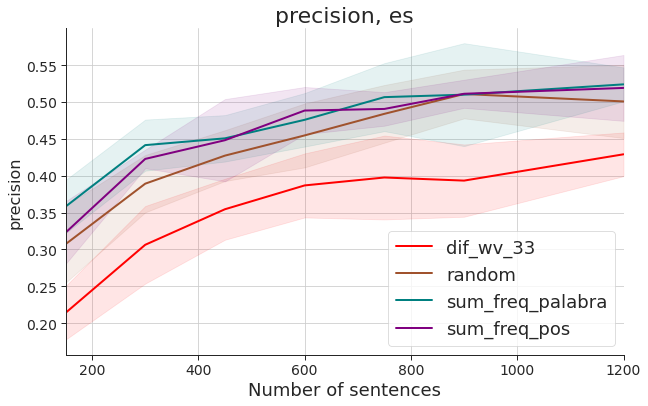

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

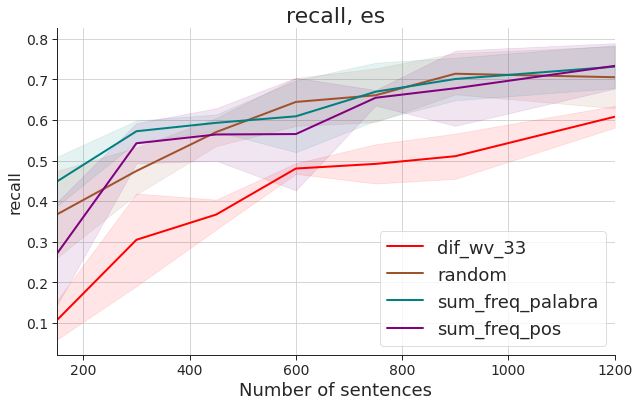

In [ ]:
resultados = []
for iteracion in range(5):
  for archivo in df_resultado_postproceso["archivo"].unique():
    for num in df_resultado_postproceso["num"].unique():
      prec, rec, f1 = calcula_metricas(df_resultado_postproceso.loc[(df_resultado_postproceso["lan"] == "es") &
                                                                    (df_resultado_postproceso["num"] == num) &
                                                                     (df_resultado_postproceso["archivo"] == archivo) &
                                                                     (df_resultado_postproceso["iteracion"] == iteracion),:])
      resultados.append([iteracion, archivo, num, prec, rec, f1])
df_val = pd.DataFrame(resultados, columns=["iteracion", "dataset", "num_palabras","precision", "recall", "f1_score"])
df_val_agg = df_val.groupby(["dataset", "num_palabras"]).agg({"precision": [np.mean, np.std], "recall": [np.mean, np.std],"f1_score": [np.mean, np.std]}).reset_index()
metricas = ["f1_score", "precision", "recall"]
color_dict = {0: "red", 1: "sienna", 2: "teal", 3: "purple"}
for metrica in metricas:
  labels=[]
  for color_id, dataset in enumerate(df_val_agg["dataset"].unique()):
    df_tmp = pd.concat([df_val_agg[df_val_agg["dataset"] == dataset]["num_palabras"], df_val_agg[df_val_agg["dataset"] == dataset][(metrica, "mean")]],axis=1)
    df_tmp.columns = ["num_palabras", metrica]
    plot_with_bars( df_tmp, df_val_agg.loc[df_val_agg["dataset"] == dataset][(metrica, "std")].values, color=color_dict[color_id])
    labels.append(dataset)
  plt.legend(labels=labels, prop={'size': 18})
  plt.title(metrica + ", es", size=22)
  plt.xlim([150,1200])
  plt.xlabel('Number of sentences', fontsize=18)
  plt.ylabel(metrica, fontsize=16)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.savefig(raiz+metrica+"_es_dos_long.svg")
  plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

No hay etiquetas P


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

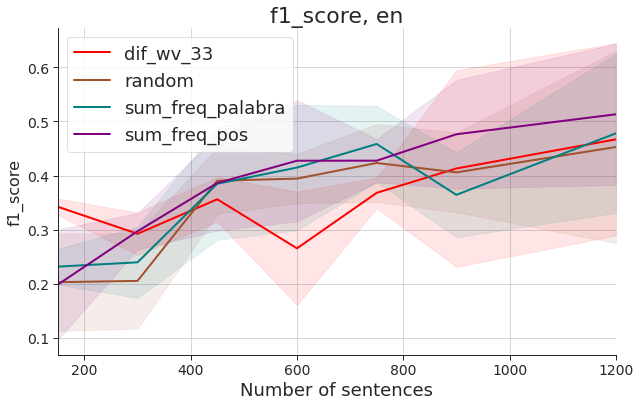

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

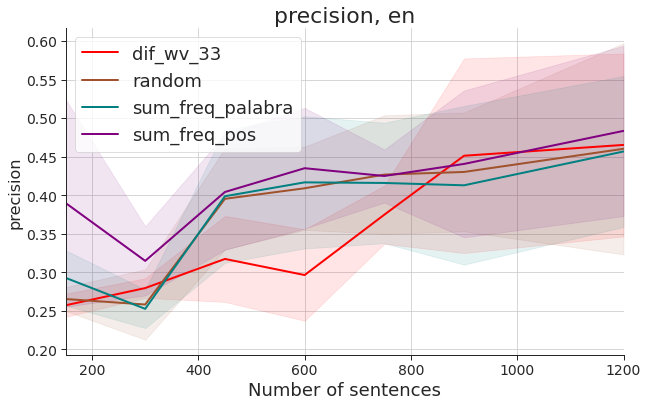

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

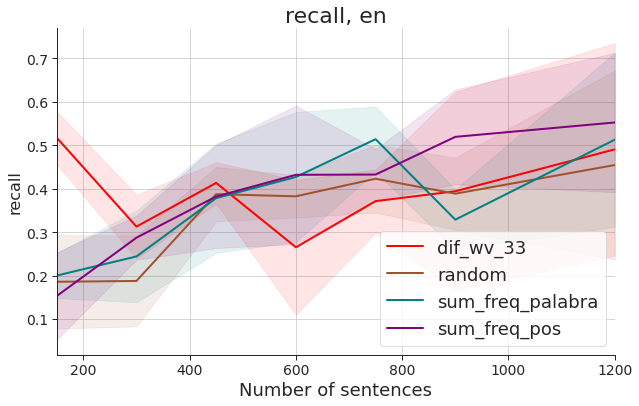

In [ ]:
resultados = []
for iteracion in range(5):
  for archivo in df_resultado_postproceso["archivo"].unique():
    for num in df_resultado_postproceso["num"].unique():
      prec, rec, f1 = calcula_metricas(df_resultado_postproceso.loc[(df_resultado_postproceso["lan"] == "en") &
                                                                    (df_resultado_postproceso["num"] == num) &
                                                                     (df_resultado_postproceso["archivo"] == archivo) &
                                                                     (df_resultado_postproceso["iteracion"] == iteracion),:])
      resultados.append([iteracion, archivo, num, prec, rec, f1])
df_val = pd.DataFrame(resultados, columns=["iteracion", "dataset", "num_palabras","precision", "recall", "f1_score"])
df_val_agg = df_val.groupby(["dataset", "num_palabras"]).agg({"precision": [np.mean, np.std], "recall": [np.mean, np.std],"f1_score": [np.mean, np.std]}).reset_index()
metricas = ["f1_score", "precision", "recall"]
color_dict = {0: "red", 1: "sienna", 2: "teal", 3: "purple"}
for metrica in metricas:
  labels=[]
  for color_id, dataset in enumerate(df_val_agg["dataset"].unique()):
    df_tmp = pd.concat([df_val_agg[df_val_agg["dataset"] == dataset]["num_palabras"], df_val_agg[df_val_agg["dataset"] == dataset][(metrica, "mean")]],axis=1)
    df_tmp.columns = ["num_palabras", metrica]
    plot_with_bars( df_tmp, df_val_agg.loc[df_val_agg["dataset"] == dataset][(metrica, "std")].values, color=color_dict[color_id])
    labels.append(dataset)
  plt.legend(labels=labels, prop={'size': 18})
  plt.title(metrica+ ", en", size=22)
  plt.xlim([150,1200])
  plt.xlabel('Number of sentences', fontsize=18)
  plt.ylabel(metrica, fontsize=16)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.savefig(raiz+metrica+"_en_dos_long.svg")
  plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

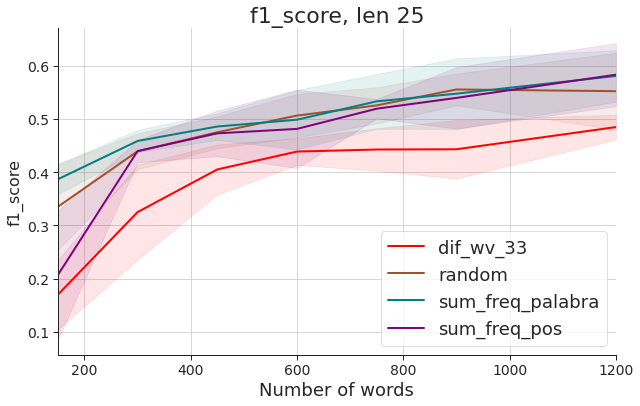

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

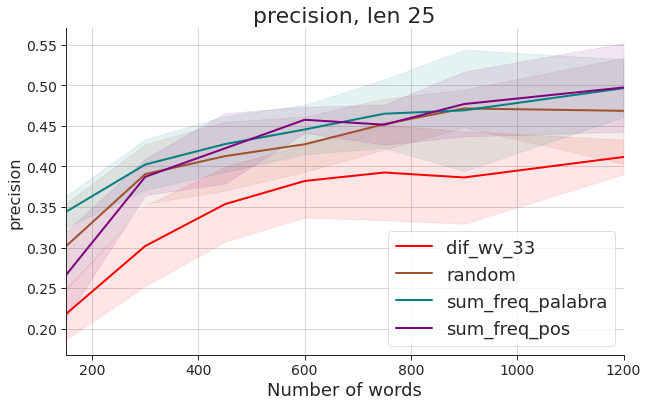

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

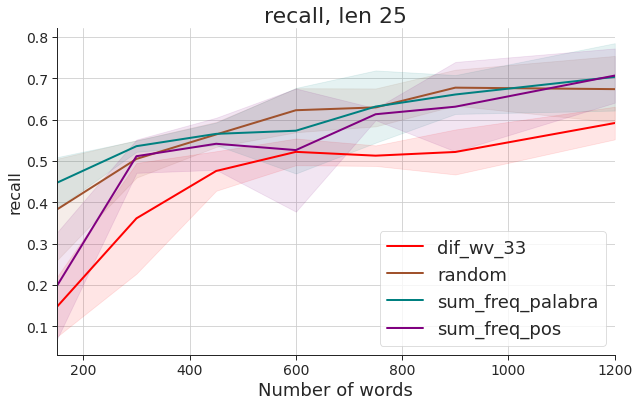

In [ ]:
resultados = []
for iteracion in range(5):
  for archivo in df_resultado_postproceso["archivo"].unique():
    for num in df_resultado_postproceso["num"].unique():
      prec, rec, f1 = calcula_metricas(df_resultado_postproceso.loc[(df_resultado_postproceso["MAX_LEN"] == 25) &
                                                                    (df_resultado_postproceso["num"] == num) &
                                                                     (df_resultado_postproceso["archivo"] == archivo) &
                                                                     (df_resultado_postproceso["iteracion"] == iteracion),:])
      resultados.append([iteracion, archivo, num, prec, rec, f1])
df_val = pd.DataFrame(resultados, columns=["iteracion", "dataset", "num_palabras","precision", "recall", "f1_score"])
df_val_agg = df_val.groupby(["dataset", "num_palabras"]).agg({"precision": [np.mean, np.std], "recall": [np.mean, np.std],"f1_score": [np.mean, np.std]}).reset_index()
metricas = ["f1_score", "precision", "recall"]
color_dict = {0: "red", 1: "sienna", 2: "teal", 3: "purple"}
for metrica in metricas:
  labels=[]
  for color_id, dataset in enumerate(df_val_agg["dataset"].unique()):
    df_tmp = pd.concat([df_val_agg[df_val_agg["dataset"] == dataset]["num_palabras"], df_val_agg[df_val_agg["dataset"] == dataset][(metrica, "mean")]],axis=1)
    df_tmp.columns = ["num_palabras", metrica]
    plot_with_bars( df_tmp, df_val_agg.loc[df_val_agg["dataset"] == dataset][(metrica, "std")].values, color=color_dict[color_id])
    labels.append(dataset)
  plt.legend(labels=labels, prop={'size': 18})
  plt.title(metrica +", len 25", size=22)
  plt.xlim([150,1200])
  plt.xlabel('Number of words', fontsize=18)
  plt.ylabel(metrica, fontsize=16)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.savefig(raiz+metrica+"_25_dos_long.svg")
  plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

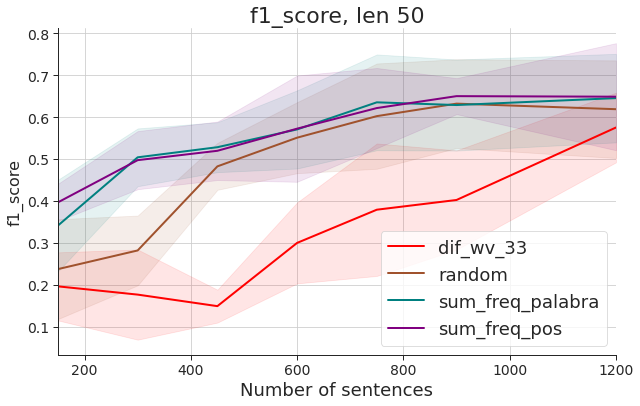

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

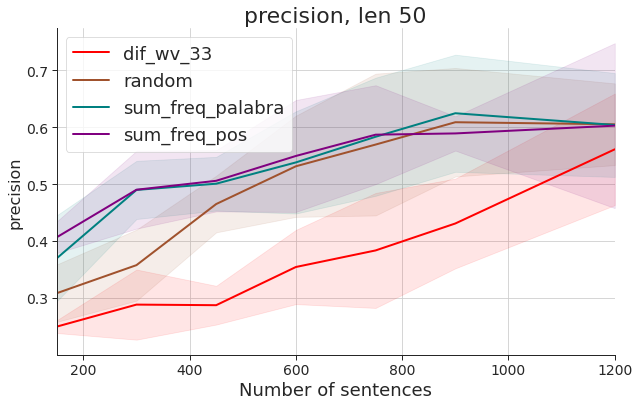

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

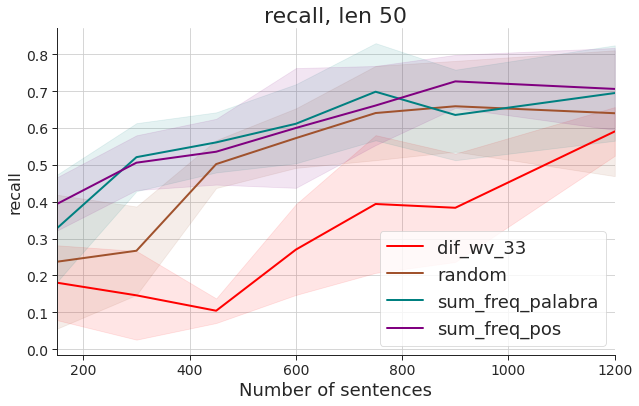

In [ ]:
resultados = []
for iteracion in range(5):
  for archivo in df_resultado_postproceso["archivo"].unique():
    for num in df_resultado_postproceso["num"].unique():
      prec, rec, f1 = calcula_metricas(df_resultado_postproceso.loc[(df_resultado_postproceso["MAX_LEN"] == 50) &
                                                                    (df_resultado_postproceso["num"] == num) &
                                                                     (df_resultado_postproceso["archivo"] == archivo) &
                                                                     (df_resultado_postproceso["iteracion"] == iteracion),:])
      resultados.append([iteracion, archivo, num, prec, rec, f1])
df_val = pd.DataFrame(resultados, columns=["iteracion", "dataset", "num_palabras","precision", "recall", "f1_score"])
df_val_agg = df_val.groupby(["dataset", "num_palabras"]).agg({"precision": [np.mean, np.std], "recall": [np.mean, np.std],"f1_score": [np.mean, np.std]}).reset_index()
metricas = ["f1_score", "precision", "recall"]
color_dict = {0: "red", 1: "sienna", 2: "teal", 3: "purple"}
for metrica in metricas:
  labels=[]
  for color_id, dataset in enumerate(df_val_agg["dataset"].unique()):
    df_tmp = pd.concat([df_val_agg[df_val_agg["dataset"] == dataset]["num_palabras"], df_val_agg[df_val_agg["dataset"] == dataset][(metrica, "mean")]],axis=1)
    df_tmp.columns = ["num_palabras", metrica]
    plot_with_bars( df_tmp, df_val_agg.loc[df_val_agg["dataset"] == dataset][(metrica, "std")].values, color=color_dict[color_id])
    labels.append(dataset)
  plt.legend(labels=labels, prop={'size': 18})
  plt.title(metrica+", len 50", size=22)
  plt.xlim([150,1200])
  plt.xlabel('Number of sentences', fontsize=18)
  plt.ylabel(metrica, fontsize=16)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.savefig(raiz+metrica+"_50_dos_long.svg")
  plt.show()